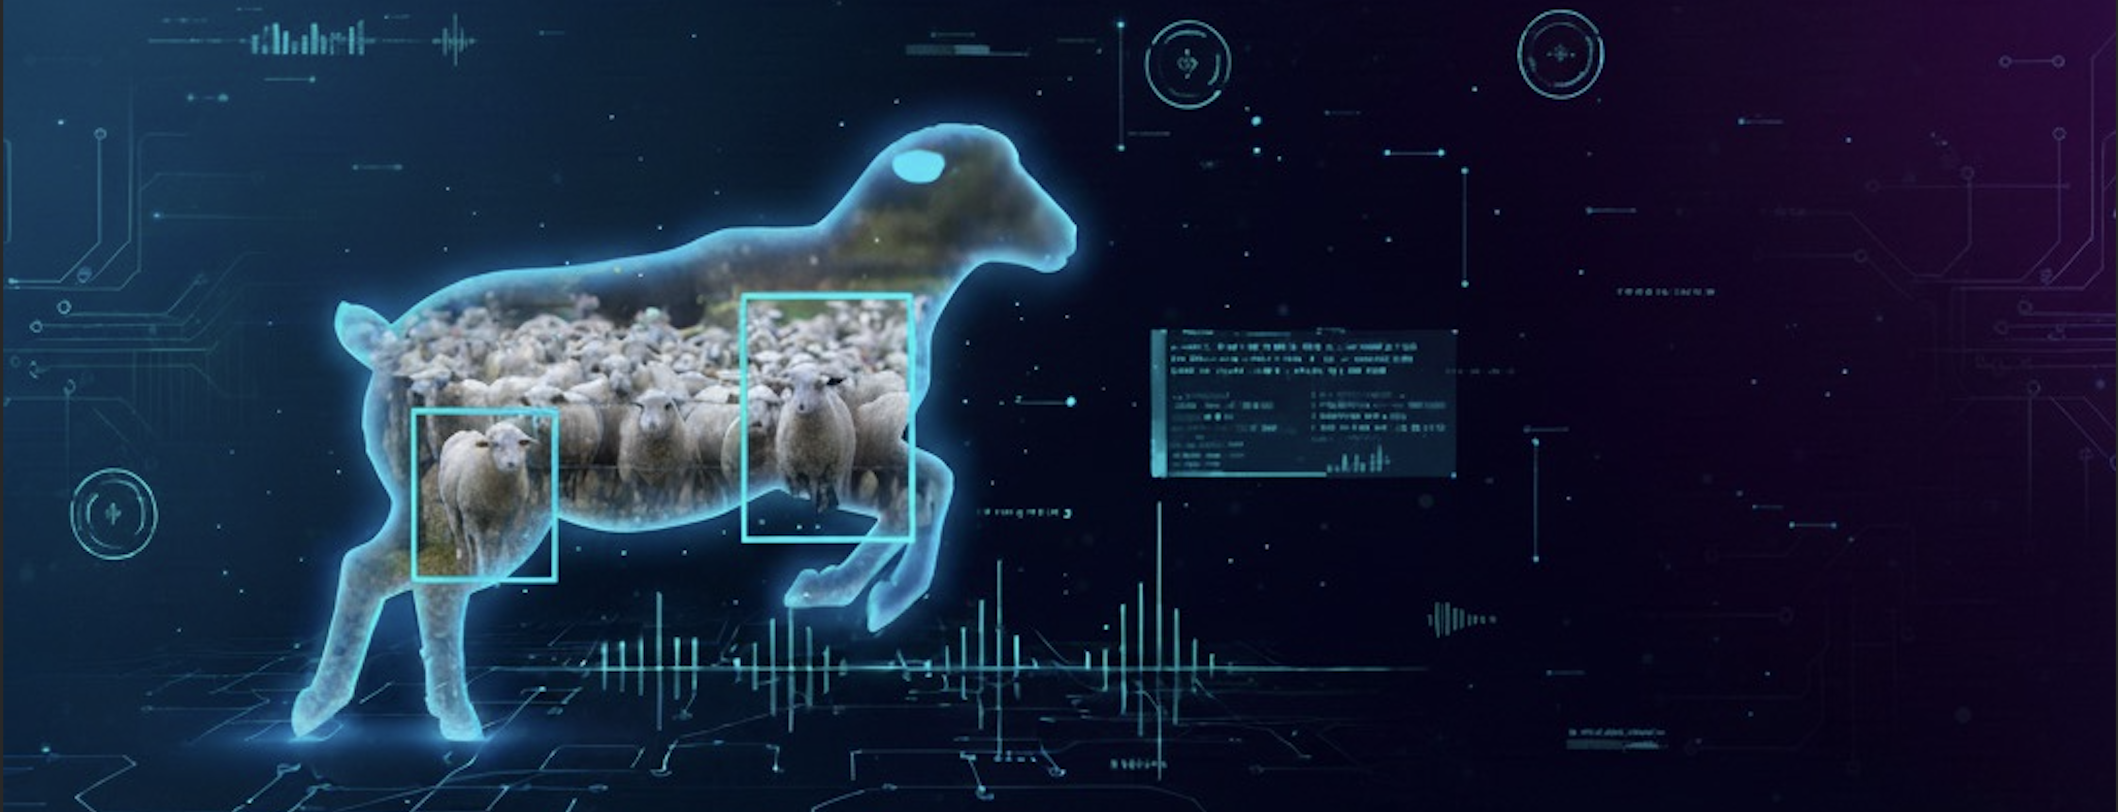

# A bárányok hallgatnak

Utazás közben egy mező mellett haladtatok el, ahol rengeteg bárányt láttatok. A családoddal fogadást kötöttetek: aki a legpontosabban tippeli meg, hány bárány van a mezőn, az kap egy kis jutalmat. Hogy eldöntsétek, ki nyer, készítettél egy rövid videót a bárányokról, majd a mesterséges intelligenciát hívtad segítségül.
A feladatban a YOLO objektumdetektáló modellt használjuk. Ez a modell képkockánként képes megtalálni az érdekes objektumokat (pl. bárányokat) és egy bounding box-al jelezni őket. A detektálás azonban önmagában csak egy képkockáról ad információt: megmondja, hogy épp most hány bárány látható.
Ahhoz, hogy ugyanazt a bárányt a következő képkockákon is felismerjük, szükség van objektumkövetésre (tracking). Ez biztosítja, hogy minden bárány egyedi azonosítót (ID-t) kapjon, és így nem számoljuk kétszer ugyanazt az állatot. A detektálás és követés kombinációjával a rendszer képes megszámolni, hány különböző bárány fordul elő a teljes videó során. Az alábbi kód felismeri a bárányokat, nyomon követi őket a videóban, és számon tartja az egyedi példányokat. Egészítsd ki a kódot úgy, hogy a program a végén kiírja a teljes bárányszámot, és így eldönthető legyen, ki nyerte a családi fogadást!

# Paraméterek

A modell és tracking esetén is a következő paraméteret használtuk: conf=0.05 iou=0.7.

# Megoldás
A megoldást egy egész szám formájában várjuk!

GPU: szükséges a feladathoz!

In [ ]:
# Ha bármiért elakadna a letöltés, használd a feladathoz csatolt videó fájlt!
!gdown 1FJdNMJ1yjJLjxBMeaPGOmTGpQD56T1jU

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--Downloading ultralytics-8.3.230-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 61.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 61.0 MB/s eta 0:00:00


In [2]:
import cv2
from ultralytics import YOLO

WARNING ⚠️ torchvision==0.22 is incompatible with torch==2.8.
Run 'pip install torchvision==0.23' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/tamas/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/tamas/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Load YOLOv8x model, refer to https://docs.ultralytics.com/
model = YOLO("yolov8x.pt")

# Get sheep class ID (https://docs.ultralytics.com/tasks/detect/)
sheep_class_id = next(k for k, v in model.names.items() if v.lower() == "sheep")

In [4]:
# Video paths
video_path = "sheep4.mp4"
output_path = "output_combined.mp4"

In [5]:
# Video I/O
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

In [ ]:
# Set for unique IDs
unique_sheep_ids = set()
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    # Step 1: Raw detection
    detections = model.predict(frame, conf=0.05, iou=0.7, verbose=False)[0]
    pred_boxes = detections.boxes
    print(f"Processing frame {frame_idx}, detections: {len(pred_boxes)}")
    # Step 2: Tracking (to get persistent IDs) (https://docs.ultralytics.com/modes/track/#tracking-arguments)
    track_results = model.track(frame, conf=0.05, iou=0.7, persist=True, verbose=False)[0]
    track_boxes = track_results.boxes

    sheep_in_frame = 0

    if track_boxes is not None and track_boxes.id is not None:
        for box, obj_id in zip(track_boxes, track_boxes.id):
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            if cls == sheep_class_id:
                unique_sheep_ids.add(int(obj_id))
                sheep_in_frame += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    frame,
                    f"Sheep {int(obj_id)} ({conf:.2f})",
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_PLAIN,
                    1.2,
                    (255, 255, 255),
                    1,
                )

    # Step 3: Overlay counts
    cv2.putText(
        frame,
        f"Frame Sheep: {sheep_in_frame}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (255, 255, 0),
        2,
    )
    cv2.putText(
        frame,
        f"Unique Sheep Tracked: {len(unique_sheep_ids)}",
        (20, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0, 0, 255),
        2,
    )

    out.write(frame)

cap.release()
out.release()


print(f"TOTAL UNIQUE SHEEP COUNTED: {len(unique_sheep_ids)}")

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



KeyboardInterrupt: 